In [18]:
import umap

import pandas as pd
from collections import *
import pickle
from xgboost import XGBClassifier, XGBRegressor
import xgboost
# import shap
# shap.initjs() 
from sklearn.cluster import KMeans,MiniBatchKMeans,Birch,AgglomerativeClustering,DBSCAN,OPTICS,MeanShift,SpectralClustering

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder,normalize,StandardScaler
from sklearn.metrics import roc_curve, auc, accuracy_score, make_scorer
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.linear_model import Lasso,LogisticRegression
from sklearn.svm import SVC
from sklearn.datasets import make_regression
from scipy.stats import mannwhitneyu,wilcoxon,shapiro, levene, ttest_ind,spearmanr
from sklearn.model_selection import KFold
from sklearn.cross_decomposition import PLSRegression

from sklearn.metrics import mean_absolute_percentage_error,mean_squared_error,r2_score

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from statsmodels.stats.multicomp import MultiComparison
import re
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from typing import List
import warnings
import numpy as np
import pprint
import os
import seaborn as sns
import time
from abc import ABC,abstractmethod
warnings.filterwarnings("ignore")
from combat.pycombat import pycombat
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import MaxAbsScaler, RobustScaler 
from sklearn.preprocessing import PowerTransformer, QuantileTransformer

from lifelines import CoxPHFitter
# import pingouin as pg

# Utils

## Class

In [13]:
# Analyze dataframe consisting of 2 batches 

class BatchEffectAnalyzer:

    def __init__(self, df,metab_num):
        self.df = df
        self.batches = df["batch"].unique()
        self.metab_num=metab_num
        scaler = StandardScaler()
        self.scaled_df = scaler.fit_transform(self.df.iloc[:,:metab_num])
        self.cal_pvalue_dict()
        # self.diff_size()

    def visualize(self):
        sns.clustermap(self.scaled_df)
        
    def pca(self):
        # f = plt.figure(figsize=(10,6),dpi=300)
        f = plt.figure()
        # PCA
        ax=f.add_subplot(121)
        pca = PCA()
        self.pca_result = pca.fit_transform(self.scaled_df)
        # Plot PCA result
        sns.scatterplot(x=self.pca_result[:,0], y=self.pca_result[:,1], hue=self.df["batch"]).set(title='PCA')
        # PLS-DA
        ax=f.add_subplot(122)
        pls = PLSRegression()
        pls.fit(self.scaled_df, self.df['batch'].apply(lambda x: dict(zip(self.df['batch'].values,list(range(len(self.df['batch'].values)))))[x]))
        print("PLS Components:", pls.n_components)
        # Plot PLS-DA result  
        sns.scatterplot(x=pls.x_scores_[:,0], y=pls.x_scores_[:,1], hue=self.df["batch"]).set(title='PLS_DA')

    def cal_pvalue_dict(self):
        df=self.df
        label_cols=['batch']
        # delete unwanted
        colnames = self.df.columns[:-2]
        classes=list(dict(sorted(dict(df.value_counts(label_cols[0])).items())).keys())
        print(classes)
        pvalue_dict={}
        if(len(classes)>2):
            for i,colname in enumerate(colnames):
                class_features=[]
                df=df.astype({colname:float})
                for label in classes:
                    tmp_feature=[]
                    # tmp_feature = df.loc[(df[label_cols[0]] == label)]
                    tmp_feature = df.loc[(df[label_cols[0]] == label)].loc[:, colname].tolist()
                    class_features.append(tmp_feature)

                _, p_value = kruskal(*class_features)
                pvalue_dict[colname]=p_value
        else:
            dfs = {label: df[df[label_cols[0]] == label] for label in classes}
            pvalue_dict = {}
            # apply并行运算
            pvalues = [mannwhitneyu(dfs[classes[0]][col], dfs[classes[1]][col])[1] for col in df.columns[:self.metab_num]]
            pvalue_dict = dict(zip(df.columns, pvalues))
            
        self.pvalue_dict=pvalue_dict
    def diff_size(self):
        r2_scores = []
        for batch in self.batches:
            y = self.df[self.df["batch"]==batch][self.df.columns[0]]
            r2 = r2_score(y, self.scaled_df[:,0])
            r2_scores.append(r2) 
        print("Batch effect sizes:", r2_scores)


In [3]:

# Scale dataframe 
class DataScaler:

    def __init__(self, df):
        self.df = df 
    def __ndarray2df__(self,array):
        return(pd.DataFrame(array,columns=self.df.columns))
    def standard_scaler(self):
        scaler = StandardScaler()
        return self.__ndarray2df__(scaler.fit_transform(self.df))

    def minmax_scaler(self):
        scaler = MinMaxScaler()
        return self.__ndarray2df__(scaler.fit_transform(self.df))
    
    def maxabs_scaler(self):
        scaler = MaxAbsScaler()
        return self.__ndarray2df__(scaler.fit_transform(self.df))

    def robust_scaler(self):
        scaler = RobustScaler()
        return self.__ndarray2df__(scaler.fit_transform(self.df))

    def power_transform(self):
        scaler = PowerTransformer()
        return self.__ndarray2df__(scaler.fit_transform(self.df))
    
    def quantile_transform(self):
        scaler = QuantileTransformer()
        return self.__ndarray2df__(scaler.fit_transform(self.df))
    
    def pareto_scaling(self):
        pareto_df=pd.DataFrame()
        cols = self.df.columns
        for col in cols:
            pareto_df[col] = self.df[col] / np.sqrt(self.df[col].std())
        return pareto_df
    
    def get_scaled_dicts(self):
        
        results = {}
        
        results['standard'] = self.standard_scaler()
        results['minmax'] = self.minmax_scaler() 
        results['maxabs'] = self.maxabs_scaler()
        results['robust'] = self.robust_scaler()
        # results['power'] = self.power_transform()
        results['quantile'] = self.quantile_transform()
        results['pareto'] = self.pareto_scaling()

        return results


## Functions

### Normarlization

In [4]:
# Evaluate whether the dataframe before and after tranformation remains the structure
def evaluate_normalization(df_raw, df_normalized,k=''):

    # 计算标准化前后样本spearman相关性
    corr_raw = df_raw.corr(method='spearman')
    corr_normalized = df_normalized.corr(method='spearman')
    
    # 计算相关性矩阵之间的spearmanr
    corr_corr = spearmanr(corr_raw.values.flatten(), corr_normalized.values.flatten())[0]
    if k!='':
        print(f"Sample correlations Spearman r before vs {k}: {corr_corr:.3f}")
    else:    
        print(f"Sample correlations Spearman r before vs after: {corr_corr:.3f}")
    
    return corr_corr
def apply_combat(df,metab_num):
    batch_1_num=df[df['batch']==1].shape[0]
    batch_2_num=df[df['batch']==2].shape[0]
    batch_1_num
    batch_list=[0]*batch_1_num+[1]*batch_2_num
    raw_df=df.iloc[:,:metab_num]
    raw_df=raw_df.T
    corrected_df=pycombat(raw_df,batch_list)
    corrected_df=corrected_df.T
    corrected_df=pd.concat([corrected_df,df.iloc[:,metab_num:]],axis=1)
    consensus_score=evaluate_normalization(df.iloc[:,:metab_num],corrected_df.iloc[:,:metab_num])
    print(f'Consensus score is {consensus_score}')
    return corrected_df
# sum norm a dataframe by samples to avoid variation made by different samples
def apply_sum_norm(df,metab_num):
    raw_data_df=df.iloc[:,:metab_num]
    raw_data_df['sum'] = raw_data_df.sum(axis=1)
    # 求所有sum的平均值 
    avg_sum = raw_data_df['sum'].mean()
    # 计算每行的factor
    raw_data_df['factor'] = avg_sum / raw_data_df['sum'] 
    # 使用factor乘以每行的所有值
    raw_data_df = raw_data_df.drop('sum', axis=1)
    raw_data_df = raw_data_df.multiply(raw_data_df['factor'], axis=0)
    raw_data_df = raw_data_df.drop('factor', axis=1)
    target_df=pd.concat([raw_data_df,df.iloc[:,metab_num:]],axis=1)
    consensus_score=evaluate_normalization(raw_data_df.iloc[:,:metab_num],target_df.iloc[:,:metab_num])
    print(f'Consensus score is {consensus_score}')
    return target_df

def drop_QC_columns(df):
    QC_columns=[]
    for col in df.columns:
        if 'QC' in col:
            QC_columns.append(col)
    return df.drop(columns=QC_columns)

In [5]:

# display utils
def display_all():
    pd.set_option('display.max_rows',None)
    pd.set_option('display.max_columns',None)
def display_part():
    pd.set_option('display.max_rows',8)
    pd.set_option('display.max_columns',10)


# Methods

## 20231130 New Batch Effect Correction
- process  
    Use median and a factor-like operation 
    y_corr=y_median+(y-y_median)*(x_median/y_median)  
     =(y_median-x_median)+y*(x_median/y_median)  
     =y_median+x_median*(y/y_median-1)



### Prepare Data


In [28]:
# metab_df=pd.read_csv('../data/metab_raw.csv')
metab_df=pd.read_csv('../data/metab_raw.csv')
metab_df=metab_df.iloc[:106,:-1].set_index('Sample Name')
print(metab_df.batch.value_counts())
metab_num=metab_df.shape[1]-1
metab_df['batch']=[1 if i =='b1' else 2 for i in metab_df.batch]
abnormal_sample_indexes=['210012-T','8195','2236']
metab_df.drop(index=abnormal_sample_indexes,inplace=True)
print(metab_df.batch.value_counts())


b1    56
b2    50
Name: batch, dtype: int64
1    54
2    49
Name: batch, dtype: int64


### Order Effect

#### Combat-Sum

In [42]:

m1_combatted_metab_df=apply_combat(metab_df,metab_num)
m1_sum_normed_metab_df=apply_sum_norm(m1_combatted_metab_df,metab_num)

# combatted_metab_df=combatted_metab_df.sort_index().sort_values(by='batch')

# print(metab_df.index)


Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Sample correlations Spearman r before vs after: 0.925
Consensus score is 0.9248331233142962
Sample correlations Spearman r before vs after: 1.000
Consensus score is 1.0


2-Isopropylmalic acid:128839931.8
2-Isopropylmalic acid:132436974.25821605


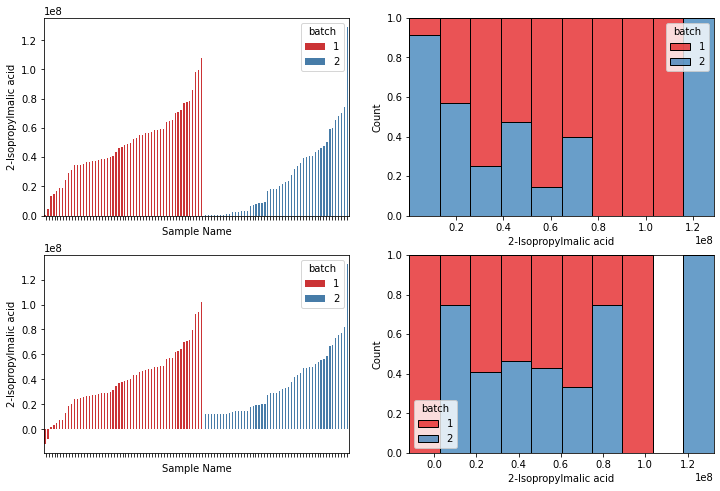

Acetyl-CoA:5595794.913
Acetyl-CoA:5481336.792314192


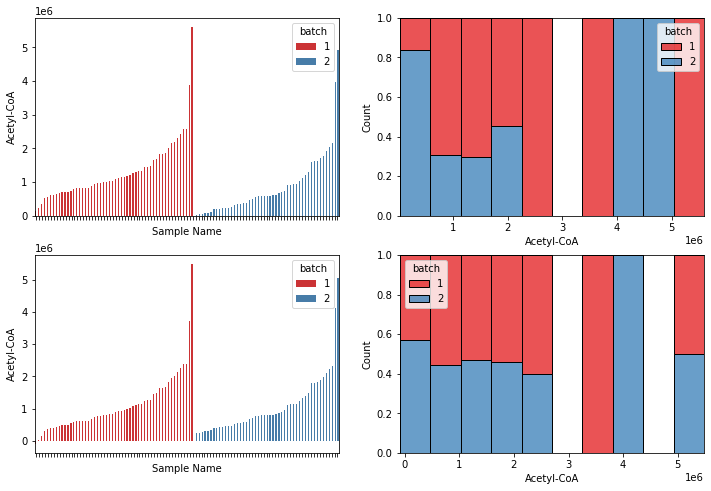

Adenine:124698878.0
Adenine:134100322.59207714


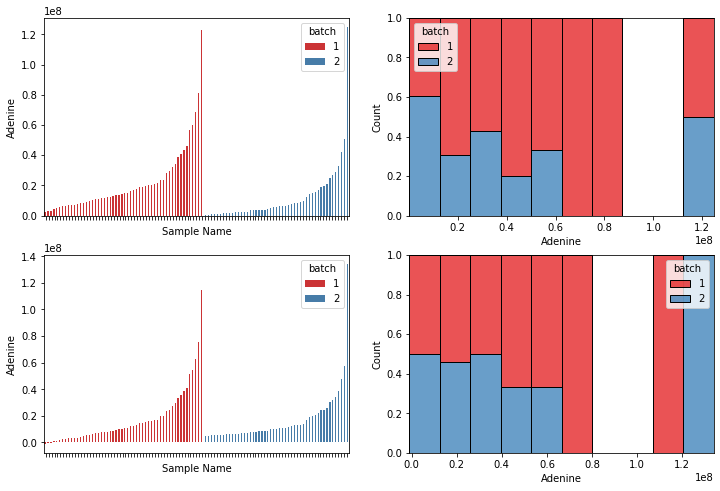

Adenosine:681341323.9
Adenosine:601408908.6475177


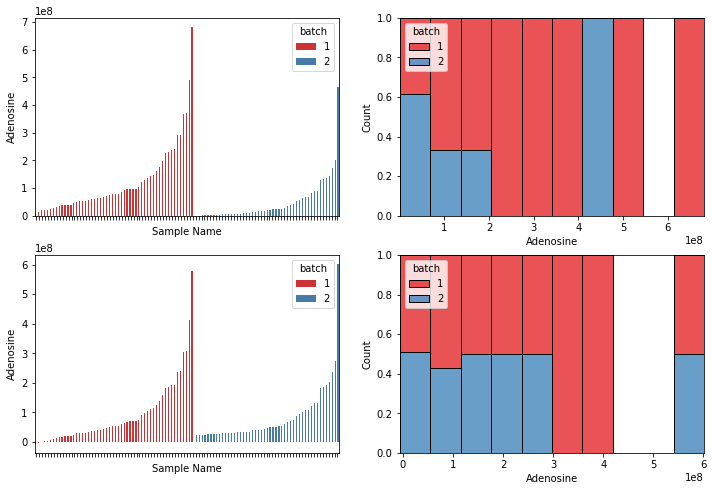

Allantoate:5459165.397000001
Allantoate:5009494.721791688


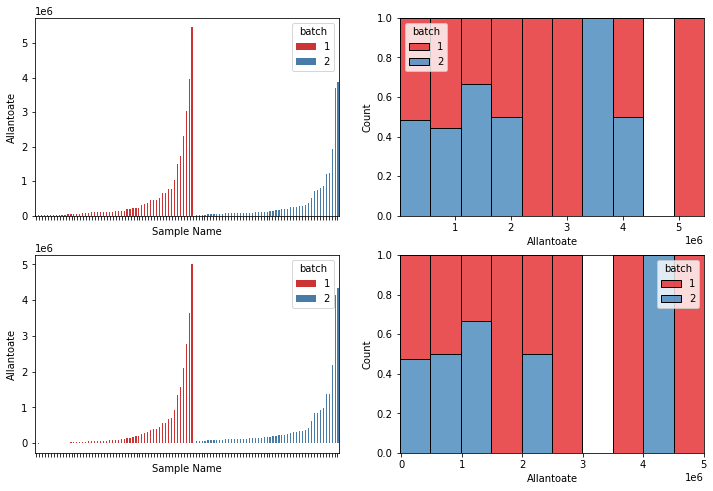

Ascorbic acid:60809447.17
Ascorbic acid:60815572.93747468


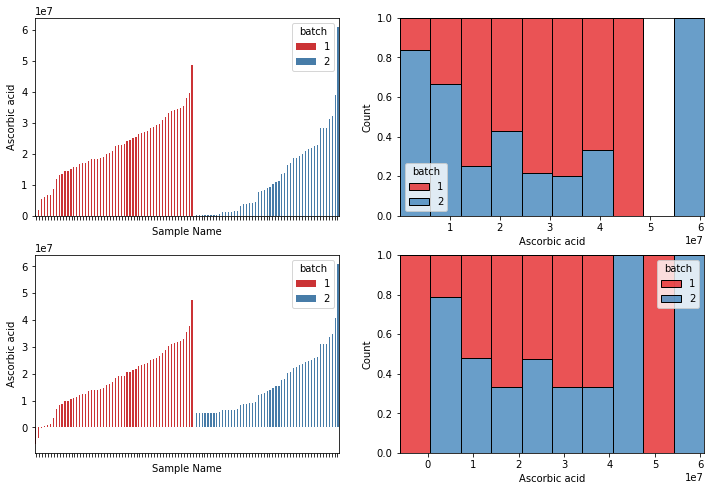

ATP:96557456.82
ATP:79502996.5954982


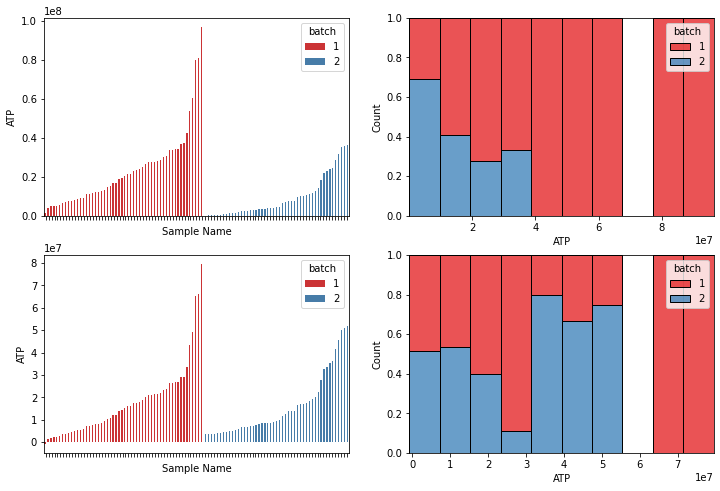

Cholesterol sulfate:30529190.56
Cholesterol sulfate:30416265.749833025


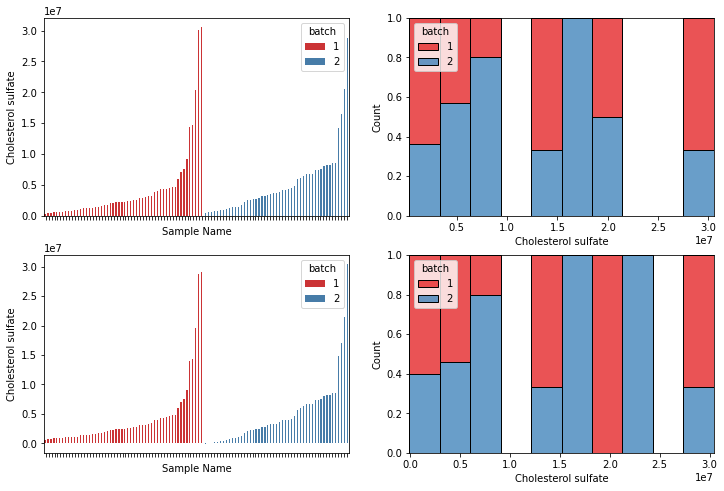

Citrate:41541882.54
Citrate:36409470.33789307


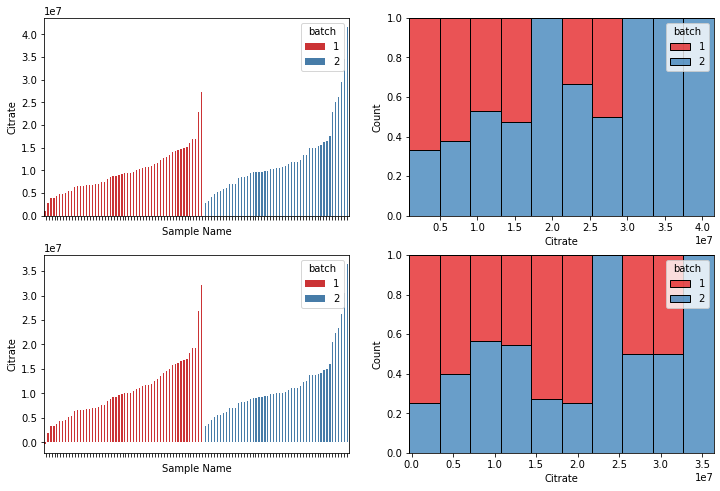

Citrate-isocitrate:156906020.6
Citrate-isocitrate:134833665.4321386


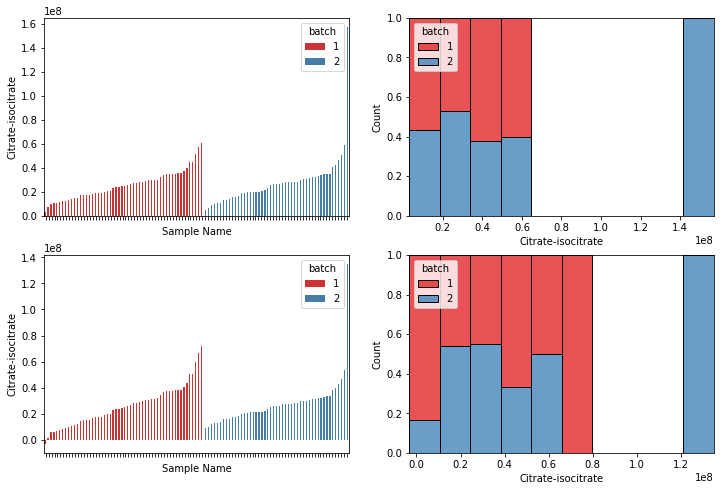

In [31]:
neg_colnames=m1_combatted_metab_df.columns[(m1_combatted_metab_df<0).any()]
# sum_normed_metab_df=sum_normed_metab_df.sort_index().sort_values(by='batch')
# neg_colnames=[i.replace('-','_') for i in neg_colnames]
for colname in neg_colnames[1:11]:
    f=plt.figure(figsize=(12,8))
    tmp_df_1=metab_df.copy(deep=True)
    tmp_df_1.reset_index(inplace=True)
    tmp_df_1=tmp_df_1.sort_values(by=['batch',colname],ascending=True)
    print(f'{colname}:{tmp_df_1[colname].max()}')

    ax=f.add_subplot(221)
    sns.barplot(data=tmp_df_1,x='Sample Name',y=colname,hue='batch',ax=ax,palette='Set1')
    ax.set_xticklabels([])
    ax=f.add_subplot(222)
    sns.histplot(data=tmp_df_1,x=colname,bins=10,hue='batch',multiple='fill',ax=ax,palette='Set1')

    
    tmp_df_2=m1_combatted_metab_df.copy(deep=True)
    tmp_df_2=tmp_df_2.loc[tmp_df_1['Sample Name'],:]
    tmp_df_2.reset_index(inplace=True)
    # tmp_df_2=tmp_df_2.sort_values(by=['batch',colname],ascending=True)
    
    print(f'{colname}:{tmp_df_2[colname].max()}')
    ax=f.add_subplot(223)
    sns.barplot(data=tmp_df_2,x='Sample Name',y=colname,hue='batch',ax=ax,palette='Set1')
    ax.set_xticklabels([])
    ax=f.add_subplot(224)
    sns.histplot(data=tmp_df_2,x=colname,bins=10,hue='batch',multiple='fill',ax=ax,palette='Set1')

    
    plt.show()

2-Isopropylmalic acid:128839931.8
2-Isopropylmalic acid:119713711.8294079


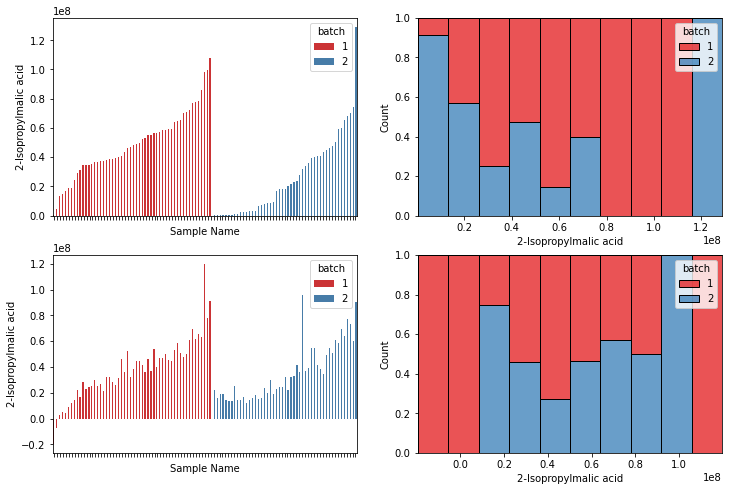

Acetyl-CoA:5595794.913
Acetyl-CoA:6098290.717031561


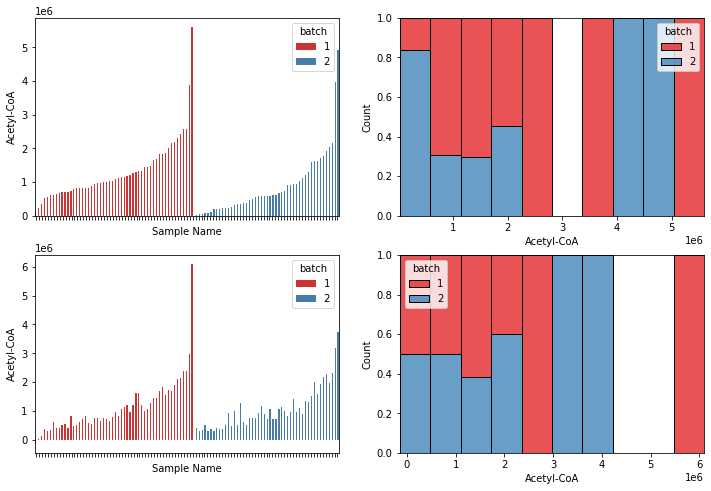

Adenine:124698878.0
Adenine:112003414.04536453


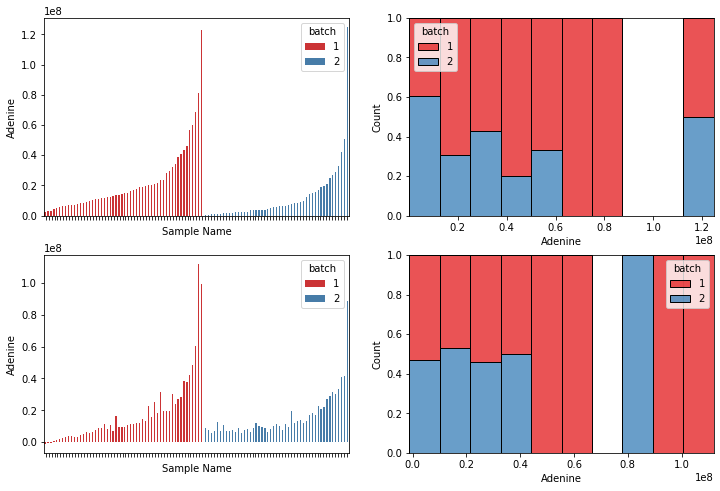

Adenosine:681341323.9
Adenosine:615307065.1524079


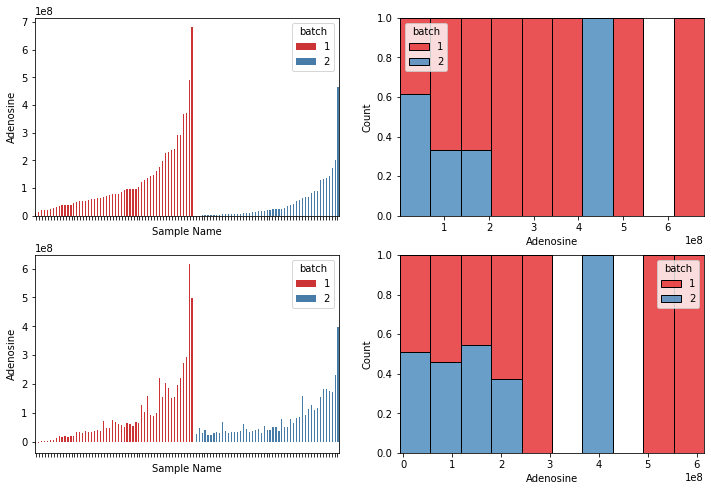

Allantoate:5459165.397000001
Allantoate:9438125.142561795


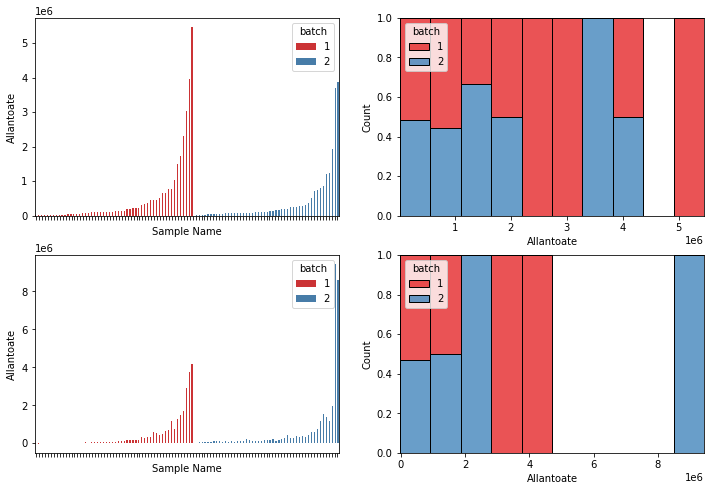

Ascorbic acid:60809447.17
Ascorbic acid:42208767.03606827


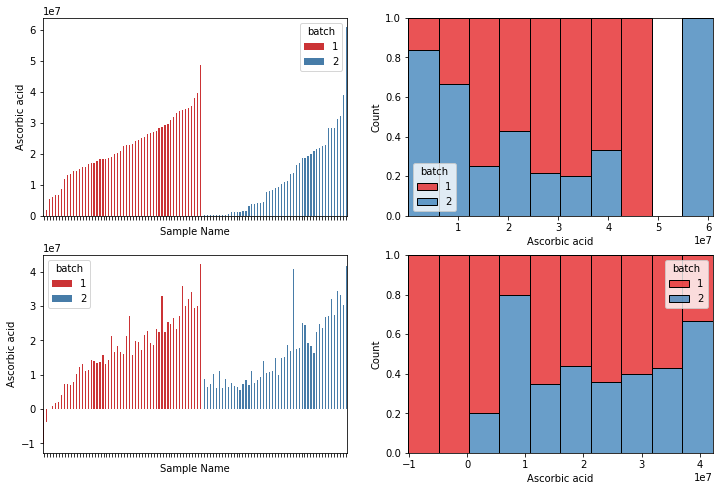

ATP:96557456.82
ATP:90310271.30971275


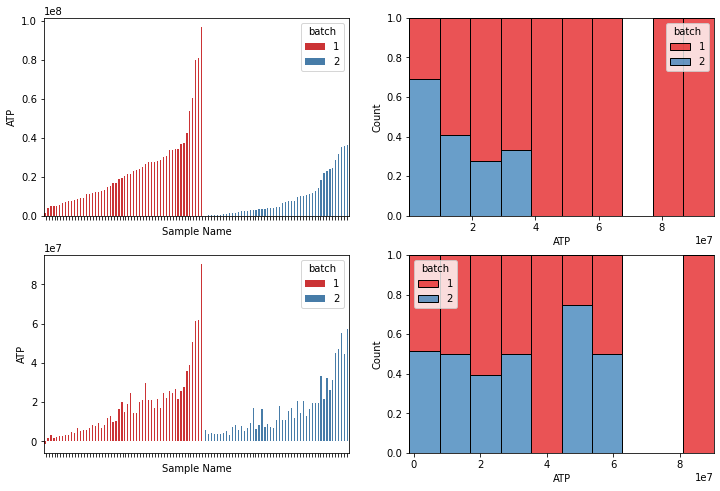

Cholesterol sulfate:30529190.56
Cholesterol sulfate:33707603.040972844


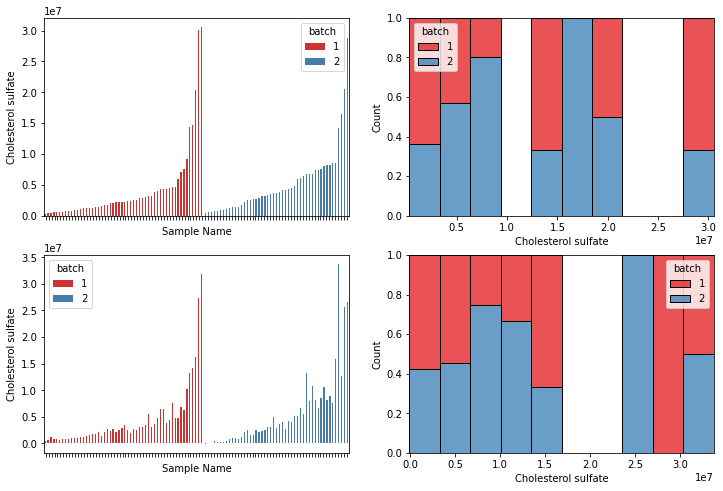

Citrate:41541882.54
Citrate:83129834.18781951


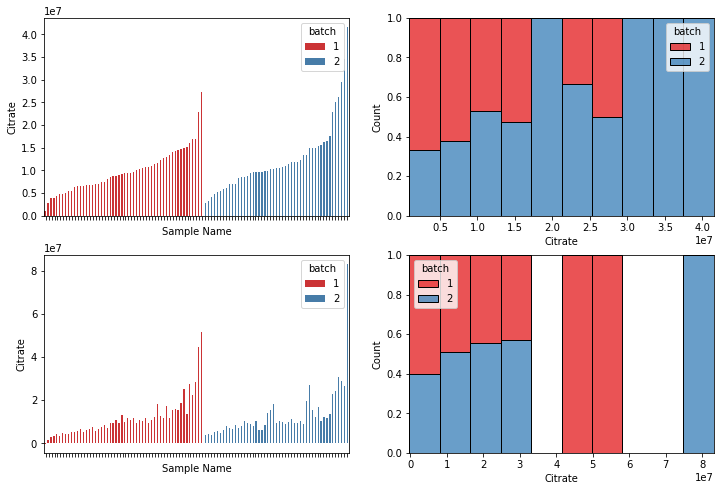

Citrate-isocitrate:156906020.6
Citrate-isocitrate:307851230.6355686


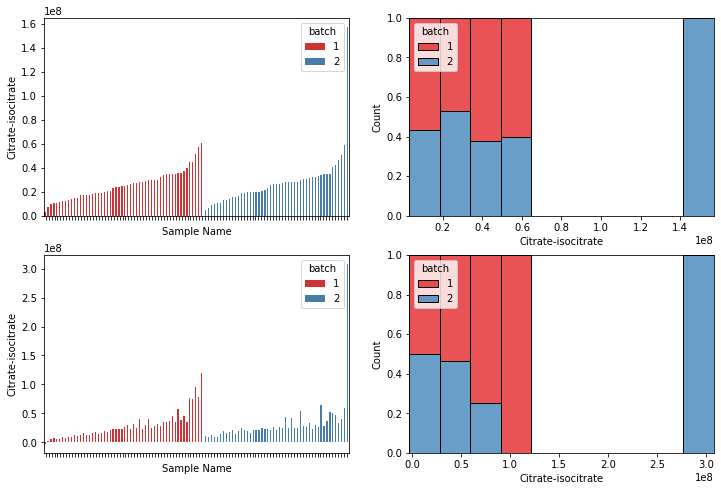

In [27]:
neg_colnames=m1_sum_normed_metab_df.columns[(m1_sum_normed_metab_df<0).any()]
# m1_sum_normed_metab_df=m1_sum_normed_metab_df.sort_index().sort_values(by='batch')
# neg_colnames=[i.replace('-','_') for i in neg_colnames]
for colname in neg_colnames[1:11]:
    f=plt.figure(figsize=(12,8))
    tmp_df_1=metab_df.copy(deep=True)
    tmp_df_1.reset_index(inplace=True)
    tmp_df_1=tmp_df_1.sort_values(by=['batch',colname],ascending=True)
    print(f'{colname}:{tmp_df_1[colname].max()}')

    ax=f.add_subplot(221)
    sns.barplot(data=tmp_df_1,x='Sample Name',y=colname,hue='batch',ax=ax,palette='Set1')
    ax.set_xticklabels([])
    ax=f.add_subplot(222)
    sns.histplot(data=tmp_df_1,x=colname,bins=10,hue='batch',multiple='fill',ax=ax,palette='Set1')

    
    tmp_df_2=m1_sum_normed_metab_df.copy(deep=True)
    tmp_df_2=tmp_df_2.loc[tmp_df_1['Sample Name'],:]
    tmp_df_2.reset_index(inplace=True)
    # tmp_df_2=tmp_df_2.sort_values(by=['batch',colname],ascending=True)
    
    print(f'{colname}:{tmp_df_2[colname].max()}')
    ax=f.add_subplot(223)
    sns.barplot(data=tmp_df_2,x='Sample Name',y=colname,hue='batch',ax=ax,palette='Set1')
    ax.set_xticklabels([])
    ax=f.add_subplot(224)
    sns.histplot(data=tmp_df_2,x=colname,bins=10,hue='batch',multiple='fill',ax=ax,palette='Set1')

    
    plt.show()

#### Sum-Combat

In [38]:

m2_sum_normed_metab_df=apply_sum_norm(metab_df,metab_num)
m2_combatted_metab_df=apply_combat(m2_sum_normed_metab_df,metab_num)


Sample correlations Spearman r before vs after: 1.000
Consensus score is 1.0
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Sample correlations Spearman r before vs after: 0.926
Consensus score is 0.9256572912138261


2-Isopropylmalic acid:128839931.8
2-Isopropylmalic acid:115475230.20824653


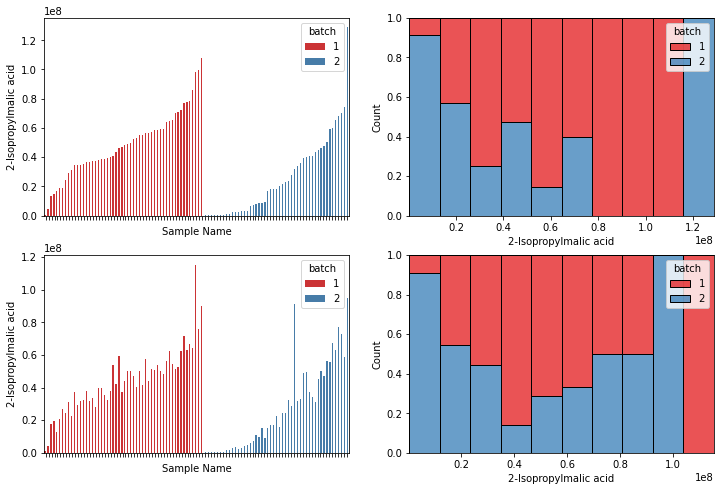

Allantoate:5459165.397000001
Allantoate:10538826.71920945


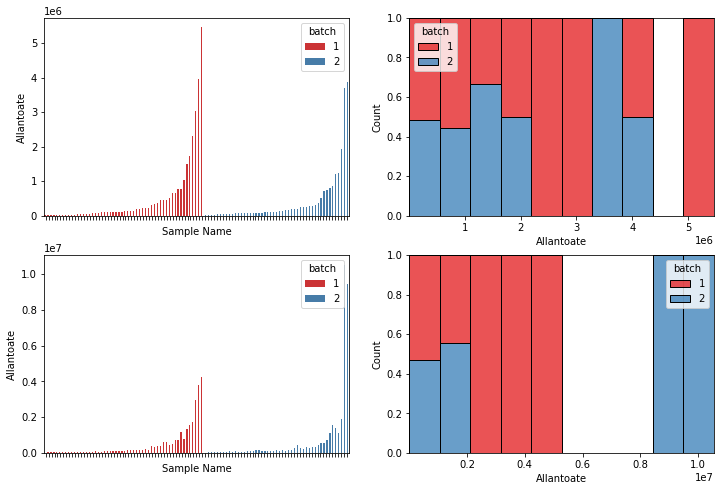

Aminoimidazole carboxamide ribonucleotide:2260276.151
Aminoimidazole carboxamide ribonucleotide:2618185.9323924202


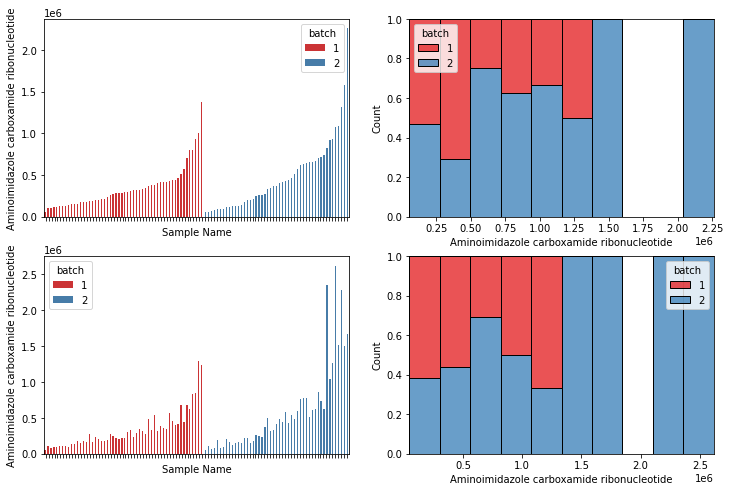

Ascorbic acid:60809447.17
Ascorbic acid:44702618.00104169


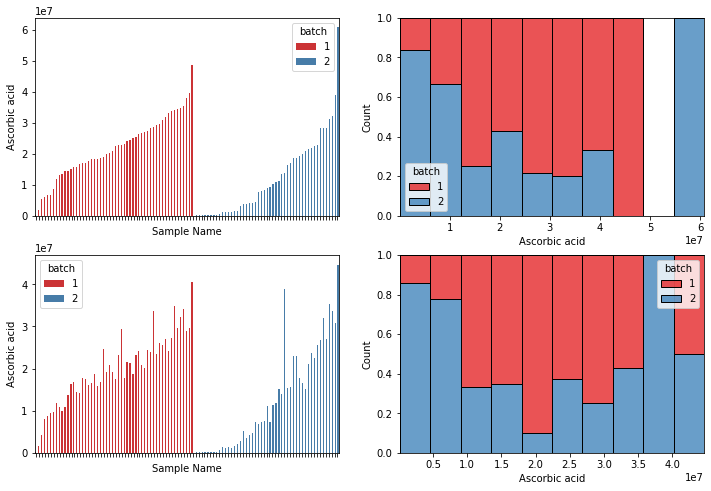

Choline:147105294.1
Choline:418734347.5410303


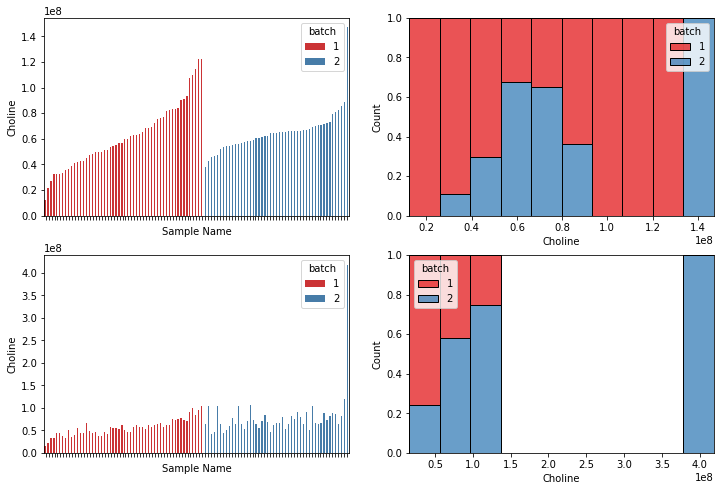

Citrate:41541882.54
Citrate:118248722.36880983


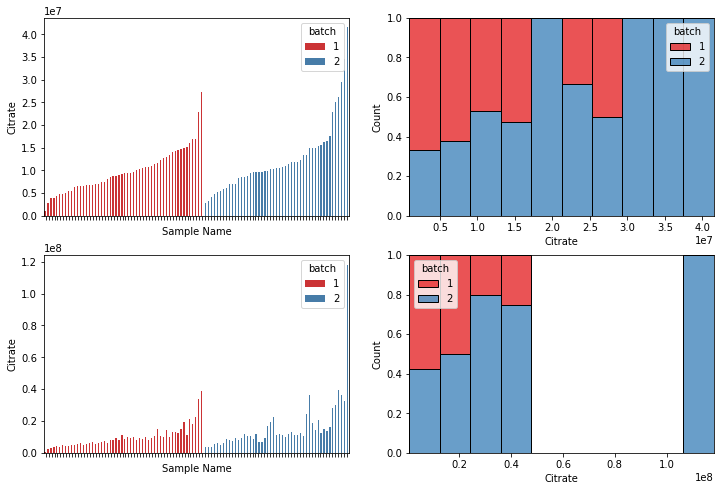

Citrate-isocitrate:156906020.6
Citrate-isocitrate:446632057.4196144


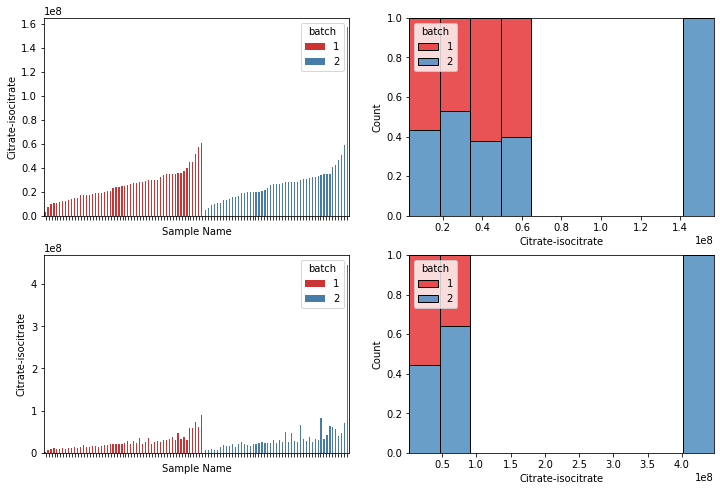

CTP:2180236.055
CTP:1979068.2048917697


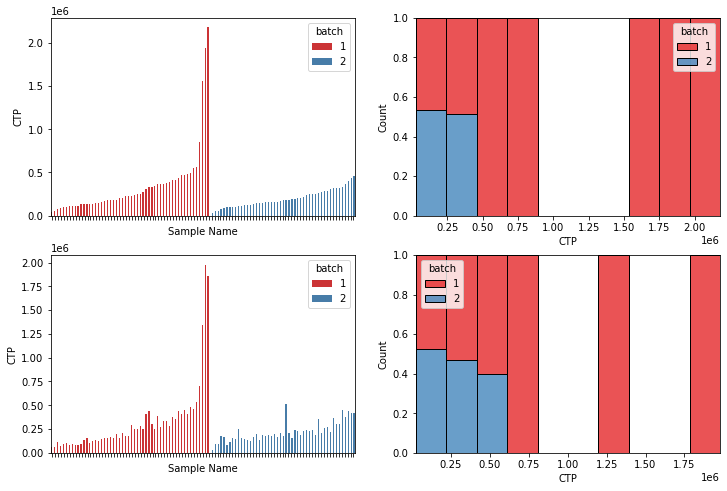

Cystathionine:101624792.4
Cystathionine:84839425.9065561


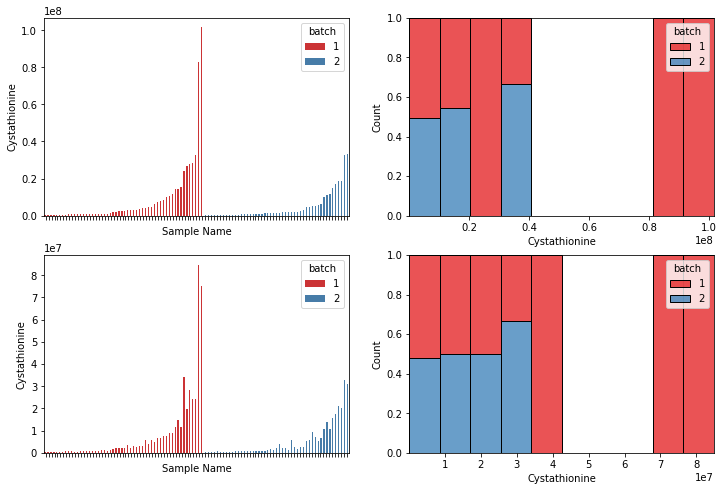

Cytidine:17210171.28
Cytidine:19147073.993523516


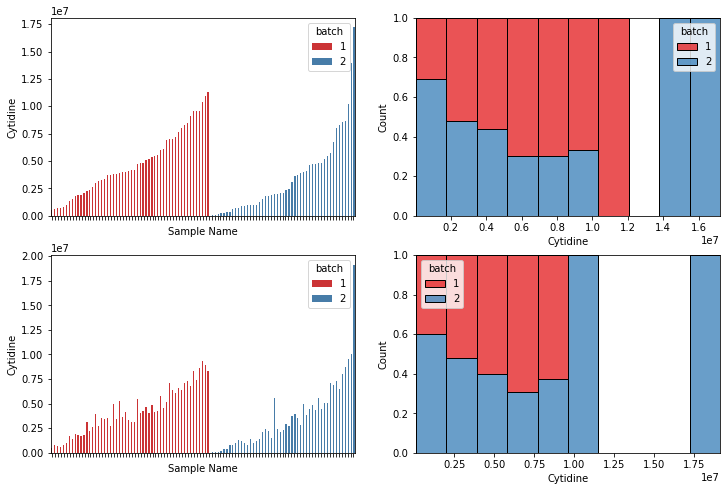

In [36]:
# sum_normed_metab_df=sum_normed_metab_df.sort_index().sort_values(by='batch')
# neg_colnames=[i.replace('-','_') for i in neg_colnames]
neg_colnames=m2_sum_normed_metab_df.columns[(m2_sum_normed_metab_df<0).any()]

for colname in neg_colnames[1:11]:
    f=plt.figure(figsize=(12,8))
    tmp_df_1=metab_df.copy(deep=True)
    tmp_df_1.reset_index(inplace=True)
    tmp_df_1=tmp_df_1.sort_values(by=['batch',colname],ascending=True)
    print(f'{colname}:{tmp_df_1[colname].max()}')

    ax=f.add_subplot(221)
    sns.barplot(data=tmp_df_1,x='Sample Name',y=colname,hue='batch',ax=ax,palette='Set1')
    ax.set_xticklabels([])
    ax=f.add_subplot(222)
    sns.histplot(data=tmp_df_1,x=colname,bins=10,hue='batch',multiple='fill',ax=ax,palette='Set1')

    
    tmp_df_2=m2_sum_normed_metab_df.copy(deep=True)
    tmp_df_2=tmp_df_2.loc[tmp_df_1['Sample Name'],:]
    tmp_df_2.reset_index(inplace=True)
    # tmp_df_2=tmp_df_2.sort_values(by=['batch',colname],ascending=True)
    
    print(f'{colname}:{tmp_df_2[colname].max()}')
    ax=f.add_subplot(223)
    sns.barplot(data=tmp_df_2,x='Sample Name',y=colname,hue='batch',ax=ax,palette='Set1')
    ax.set_xticklabels([])
    ax=f.add_subplot(224)
    sns.histplot(data=tmp_df_2,x=colname,bins=10,hue='batch',multiple='fill',ax=ax,palette='Set1')

    
    plt.show()

2-Isopropylmalic acid:128839931.8
2-Isopropylmalic acid:119462404.15860416


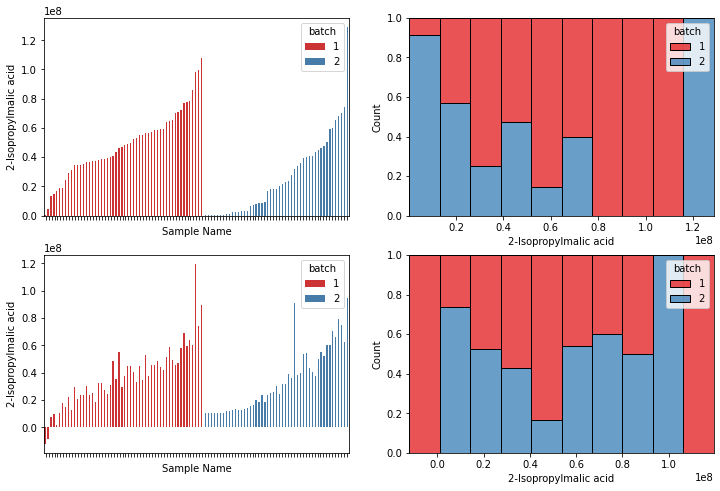

Allantoate:5459165.397000001
Allantoate:8404731.344448404


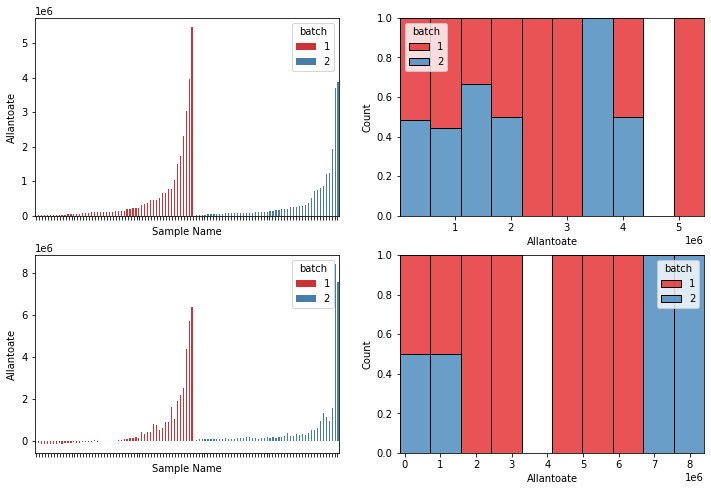

Aminoimidazole carboxamide ribonucleotide:2260276.151
Aminoimidazole carboxamide ribonucleotide:2081215.6114726195


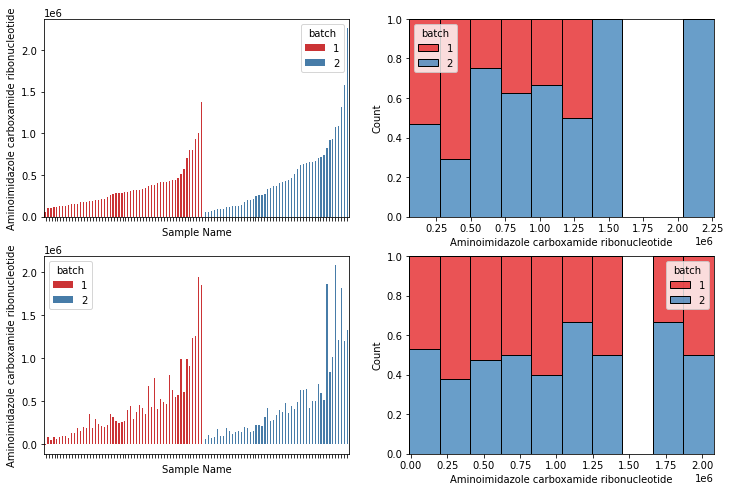

Ascorbic acid:60809447.17
Ascorbic acid:43433531.37639235


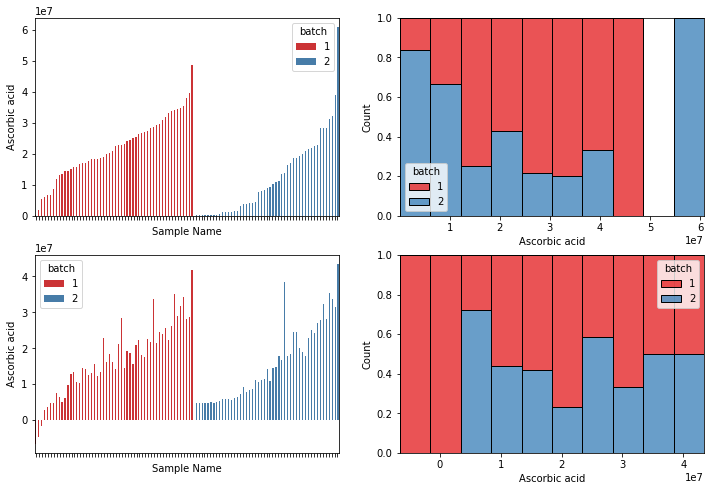

Choline:147105294.1
Choline:330544574.97017306


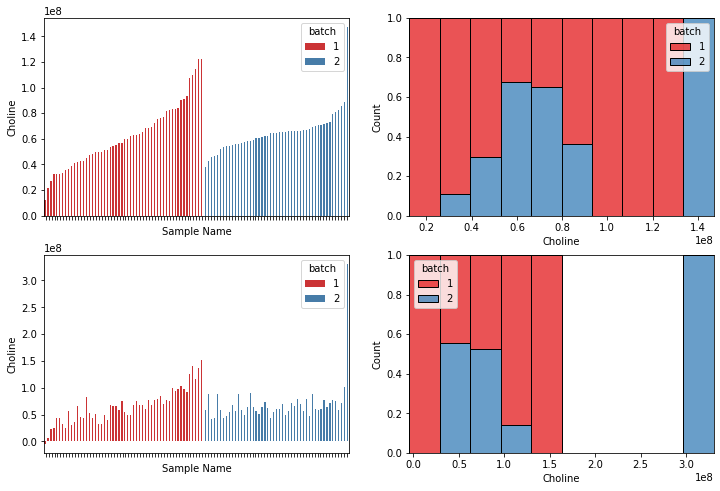

Citrate:41541882.54
Citrate:93345550.06273286


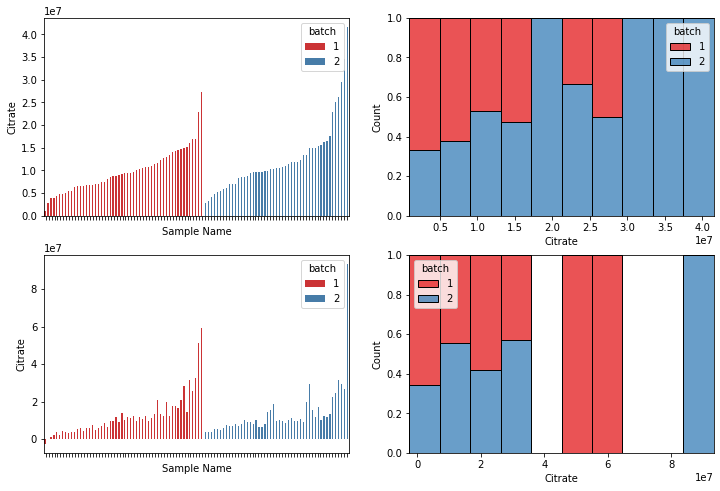

Citrate-isocitrate:156906020.6
Citrate-isocitrate:341404009.5301265


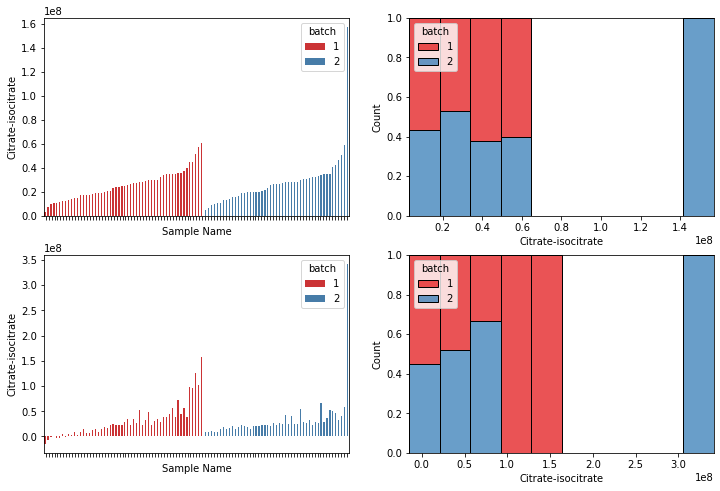

CTP:2180236.055
CTP:1582191.063580341


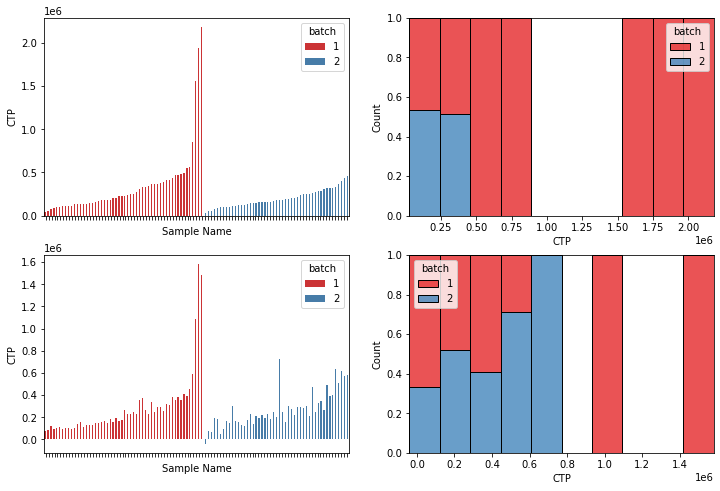

Cystathionine:101624792.4
Cystathionine:70632283.29548688


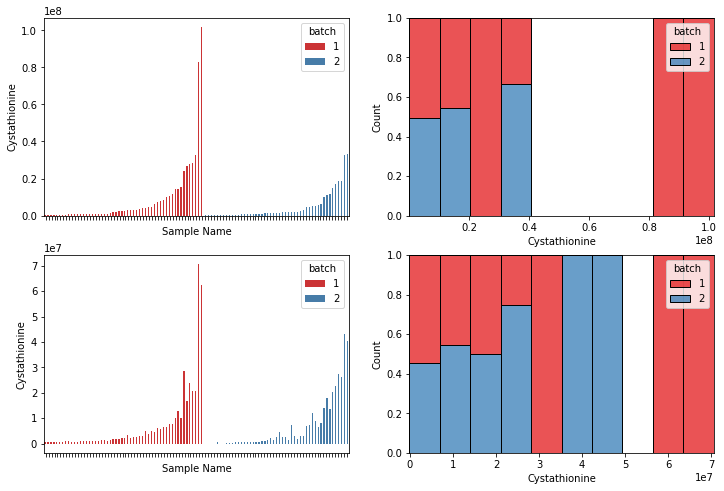

Cytidine:17210171.28
Cytidine:17287627.470214326


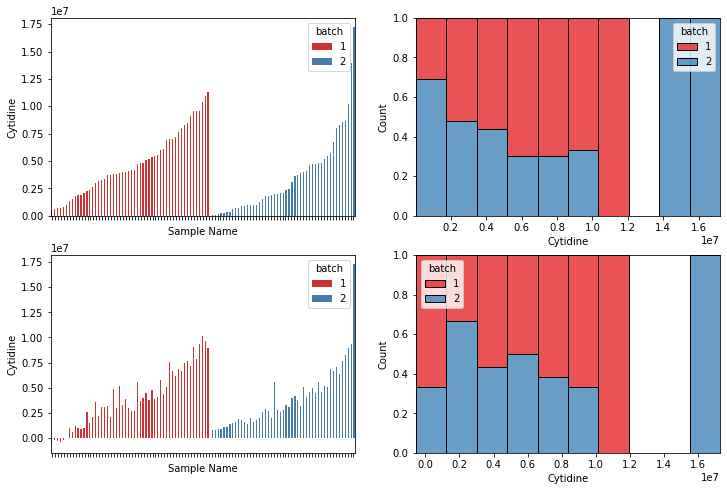

In [41]:

# m2_combatted_metab_df=m2_combatted_metab_df.sort_index().sort_values(by='batch')

# print(metab_df.index)

# neg_colnames=m2_combatted_metab_df.columns[(m2_combatted_metab_df<0).any()]
# sum_normed_metab_df=sum_normed_metab_df.sort_index().sort_values(by='batch')
# neg_colnames=[i.replace('-','_') for i in neg_colnames]
for colname in neg_colnames[1:11]:
    f=plt.figure(figsize=(12,8))
    tmp_df_1=metab_df.copy(deep=True)
    tmp_df_1.reset_index(inplace=True)
    tmp_df_1=tmp_df_1.sort_values(by=['batch',colname],ascending=True)
    print(f'{colname}:{tmp_df_1[colname].max()}')

    ax=f.add_subplot(221)
    sns.barplot(data=tmp_df_1,x='Sample Name',y=colname,hue='batch',ax=ax,palette='Set1')
    ax.set_xticklabels([])
    ax=f.add_subplot(222)
    sns.histplot(data=tmp_df_1,x=colname,bins=10,hue='batch',multiple='fill',ax=ax,palette='Set1')

    
    tmp_df_2=m2_combatted_metab_df.copy(deep=True)
    tmp_df_2=tmp_df_2.loc[tmp_df_1['Sample Name'],:]
    tmp_df_2.reset_index(inplace=True)
    # tmp_df_2=tmp_df_2.sort_values(by=['batch',colname],ascending=True)
    
    print(f'{colname}:{tmp_df_2[colname].max()}')
    ax=f.add_subplot(223)
    sns.barplot(data=tmp_df_2,x='Sample Name',y=colname,hue='batch',ax=ax,palette='Set1')
    ax.set_xticklabels([])
    ax=f.add_subplot(224)
    sns.histplot(data=tmp_df_2,x=colname,bins=10,hue='batch',multiple='fill',ax=ax,palette='Set1')

    
    plt.show()
neg_colnames=sum_normed_metab_df.columns[(sum_normed_metab_df<0).any()]


#### Comparison

2-Isopropylmalic acid:132436974.25821605
2-Isopropylmalic acid:119713711.8294079
2-Isopropylmalic acid:119462404.15860416
2-Isopropylmalic acid:115475230.20824653


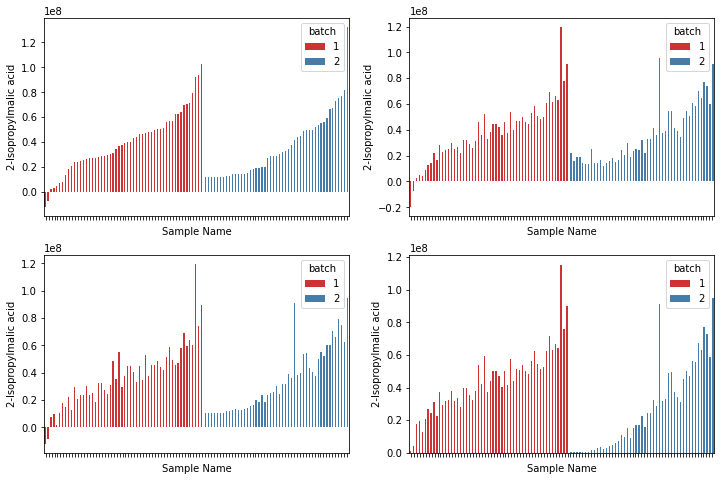

Acetyl-CoA:5481336.792314192
Acetyl-CoA:6098290.717031561
Acetyl-CoA:5655251.258009761
Acetyl-CoA:5770669.835089038


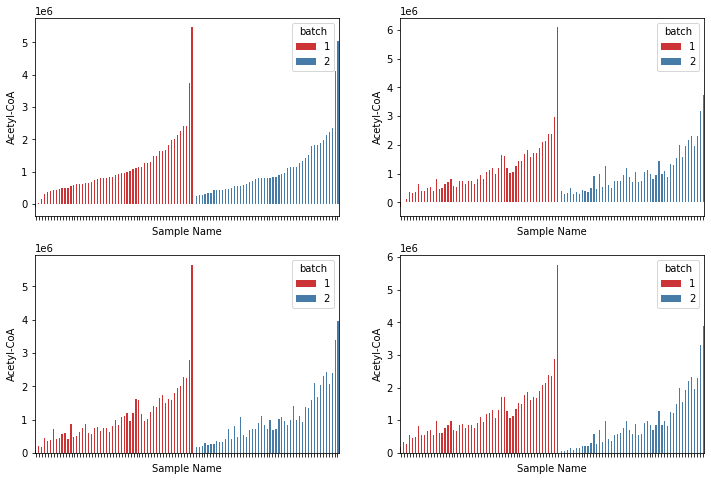

Adenine:134100322.59207714
Adenine:112003414.04536453
Adenine:101387636.16387083
Adenine:107452116.76204695


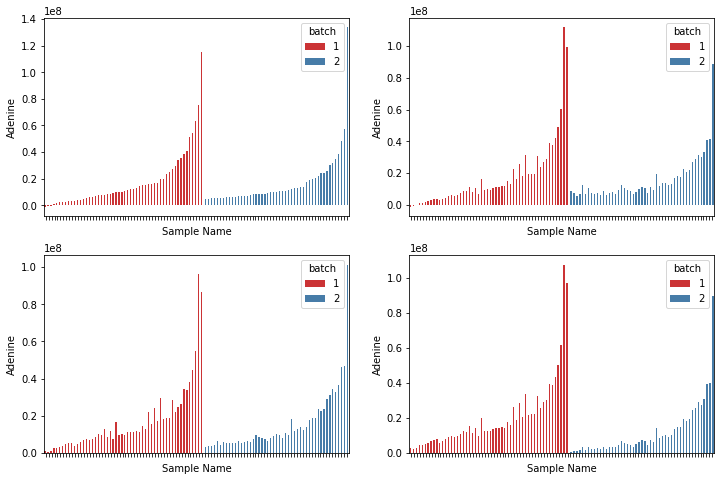

Adenosine:601408908.6475177
Adenosine:615307065.1524079
Adenosine:537158190.4905386
Adenosine:649431178.9620664


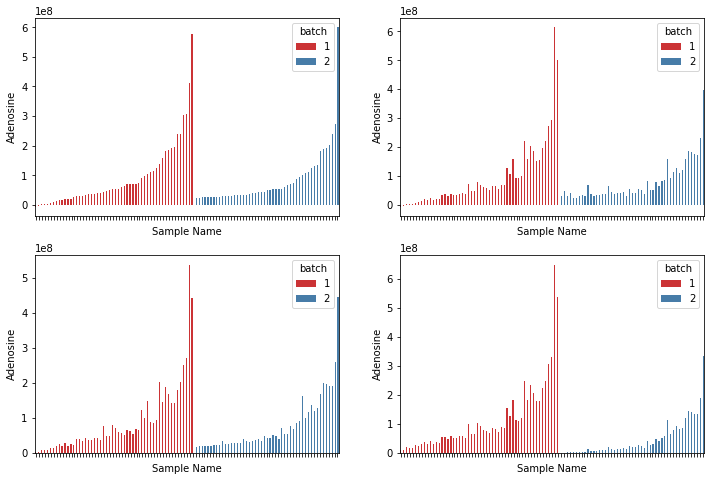

Allantoate:5009494.721791688
Allantoate:9438125.142561795
Allantoate:8404731.344448404
Allantoate:10538826.71920945


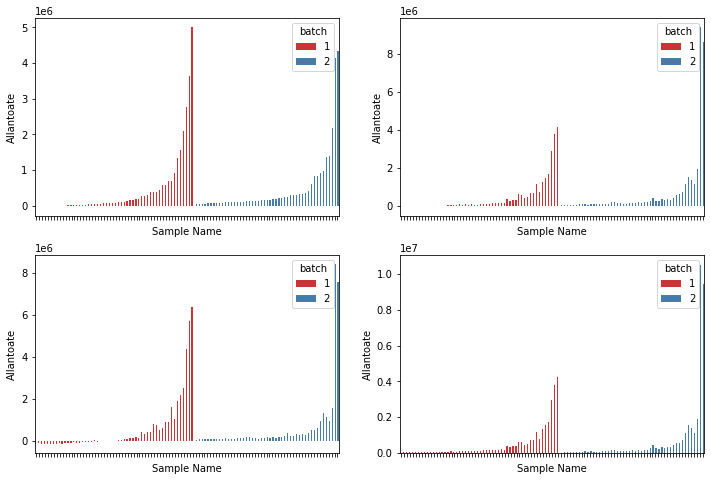

Ascorbic acid:60815572.93747468
Ascorbic acid:42208767.03606827
Ascorbic acid:43433531.37639235
Ascorbic acid:44702618.00104169


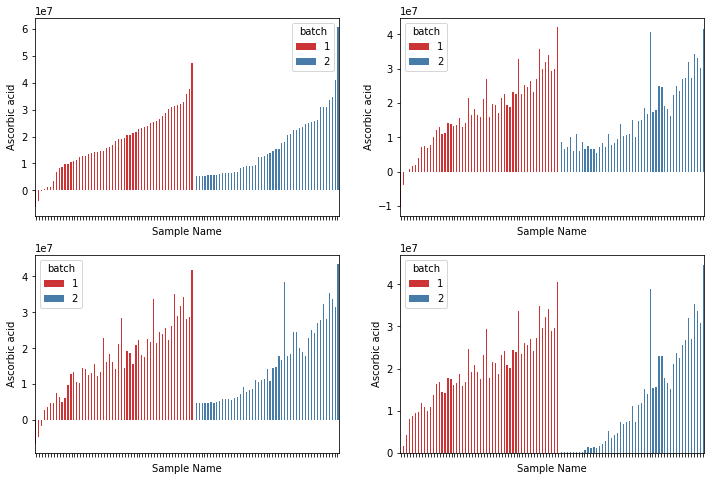

ATP:79502996.5954982
ATP:90310271.30971275
ATP:84477460.38344035
ATP:98547331.493788


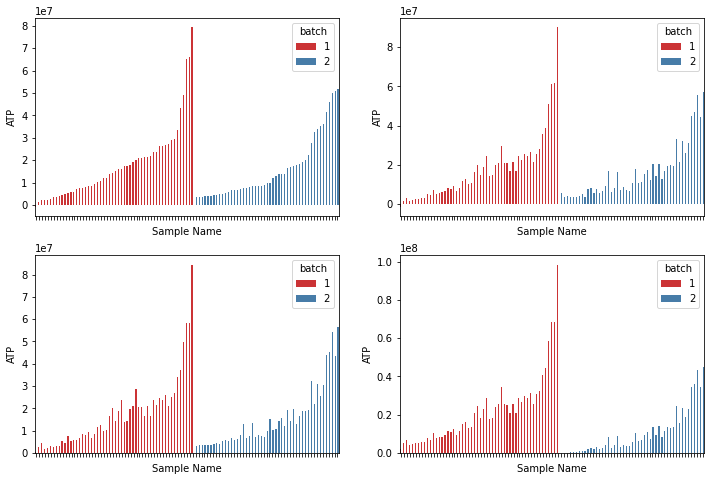

Cholesterol sulfate:30416265.749833025
Cholesterol sulfate:33707603.040972844
Cholesterol sulfate:36363364.31239733
Cholesterol sulfate:40650976.67752491


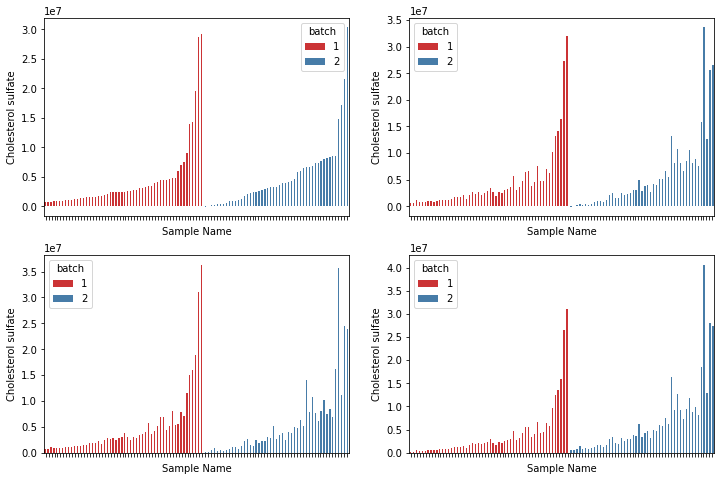

Citrate:36409470.33789307
Citrate:83129834.18781951
Citrate:93345550.06273286
Citrate:118248722.36880983


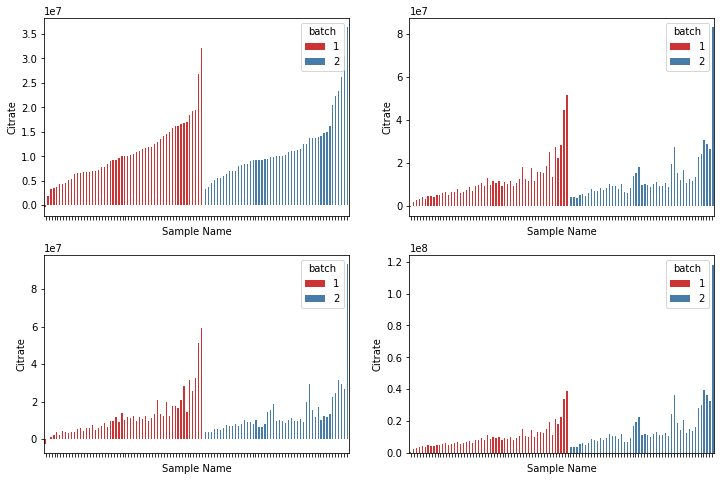

Citrate-isocitrate:134833665.4321386
Citrate-isocitrate:307851230.6355686
Citrate-isocitrate:341404009.5301265
Citrate-isocitrate:446632057.4196144


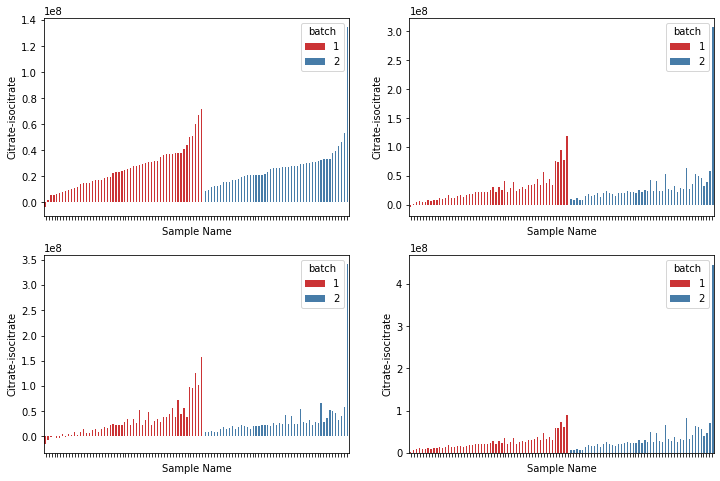

In [47]:
# sum_normed_metab_df=sum_normed_metab_df.sort_index().sort_values(by='batch')
# neg_colnames=[i.replace('-','_') for i in neg_colnames]
neg_colnames=m1_sum_normed_metab_df.columns[(m1_sum_normed_metab_df<0).any()]

for colname in neg_colnames[1:11]:
    f=plt.figure(figsize=(12,8))
    tmp_df_1=m1_combatted_metab_df.copy(deep=True)
    tmp_df_1.reset_index(inplace=True)
    tmp_df_1=tmp_df_1.sort_values(by=['batch',colname],ascending=True)
    print(f'{colname}:{tmp_df_1[colname].max()}')

    ax=f.add_subplot(221)
    sns.barplot(data=tmp_df_1,x='Sample Name',y=colname,hue='batch',ax=ax,palette='Set1')
    ax.set_xticklabels([])

    tmp_df_2=m1_sum_normed_metab_df.copy(deep=True)
    tmp_df_2=tmp_df_2.loc[tmp_df_1['Sample Name'],:]
    tmp_df_2.reset_index(inplace=True)
    ax=f.add_subplot(222)
    sns.barplot(data=tmp_df_2,x='Sample Name',y=colname,hue='batch',ax=ax,palette='Set1')
    ax.set_xticklabels([])
    print(f'{colname}:{tmp_df_2[colname].max()}')

    

    tmp_df_3=m2_combatted_metab_df.copy(deep=True)
    tmp_df_3=tmp_df_3.loc[tmp_df_1['Sample Name'],:]
    tmp_df_3.reset_index(inplace=True)

    ax=f.add_subplot(223)
    sns.barplot(data=tmp_df_3,x='Sample Name',y=colname,hue='batch',ax=ax,palette='Set1')
    ax.set_xticklabels([])
    print(f'{colname}:{tmp_df_3[colname].max()}')

    tmp_df_4=m2_sum_normed_metab_df.copy(deep=True)
    tmp_df_4=tmp_df_4.loc[tmp_df_1['Sample Name'],:]
    tmp_df_4.reset_index(inplace=True)

    ax=f.add_subplot(224)
    sns.barplot(data=tmp_df_4,x='Sample Name',y=colname,hue='batch',ax=ax,palette='Set1')
    ax.set_xticklabels([])
    print(f'{colname}:{tmp_df_4[colname].max()}')
    
    plt.show()

2-Isopropylmalic acid:119713711.8294079
2-Isopropylmalic acid:119462404.15860416


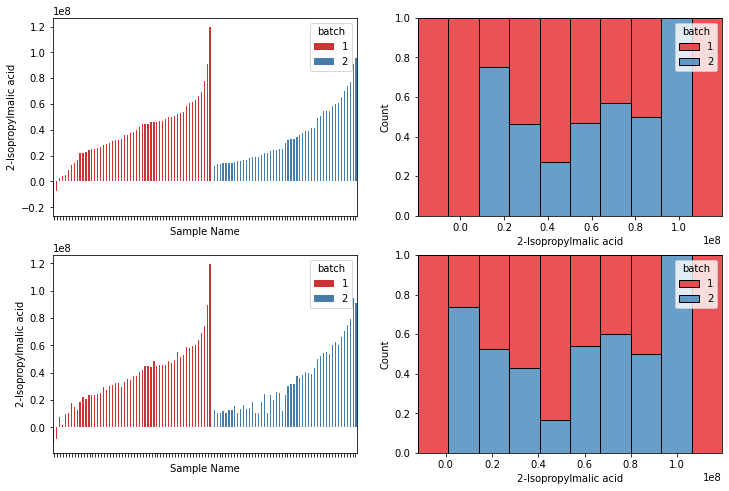

Acetyl-CoA:6098290.717031561
Acetyl-CoA:5655251.258009761


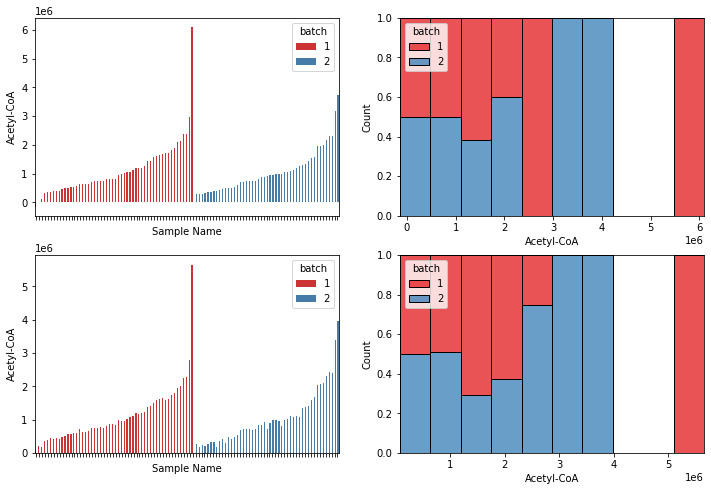

Adenine:112003414.04536453
Adenine:101387636.16387083


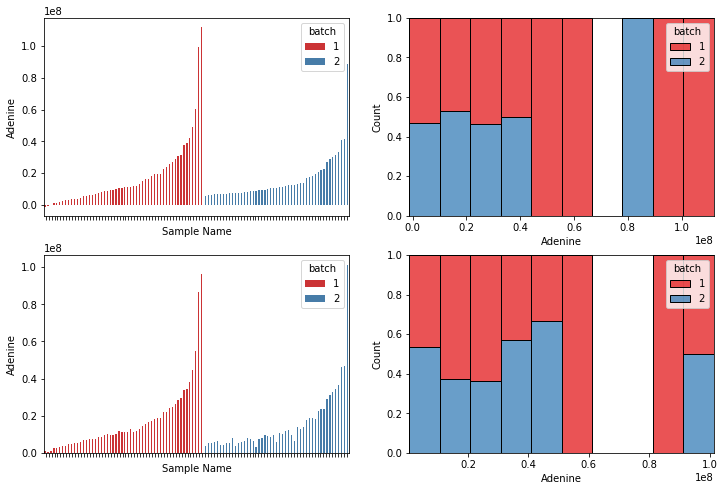

Adenosine:615307065.1524079
Adenosine:537158190.4905386


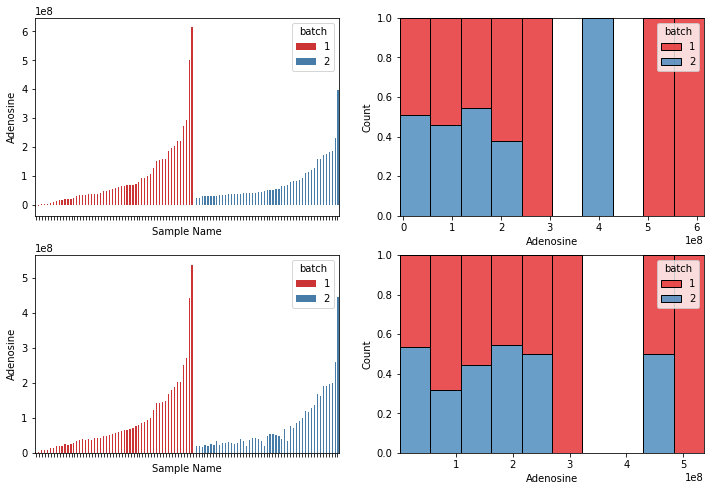

Allantoate:9438125.142561795
Allantoate:8404731.344448404


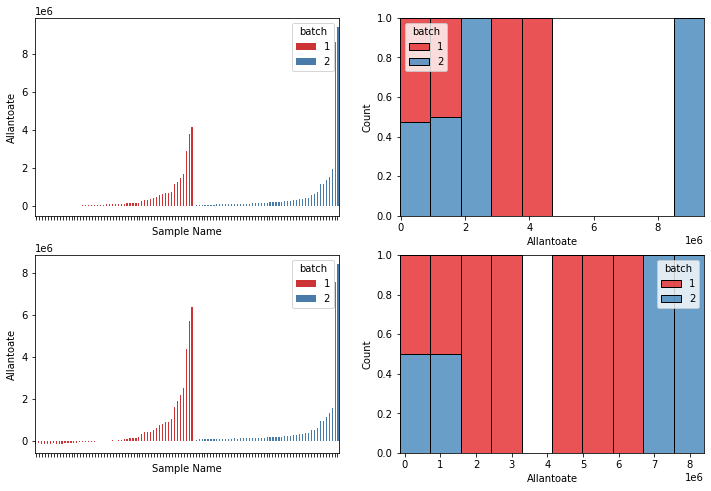

Ascorbic acid:42208767.03606827
Ascorbic acid:43433531.37639235


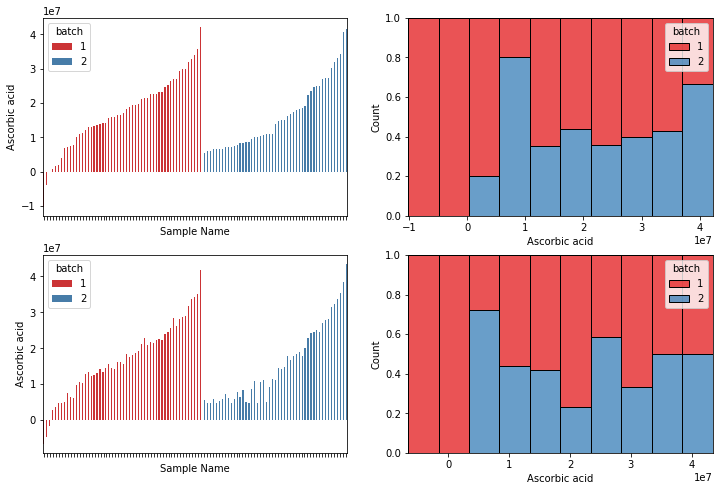

ATP:90310271.30971275
ATP:84477460.38344035


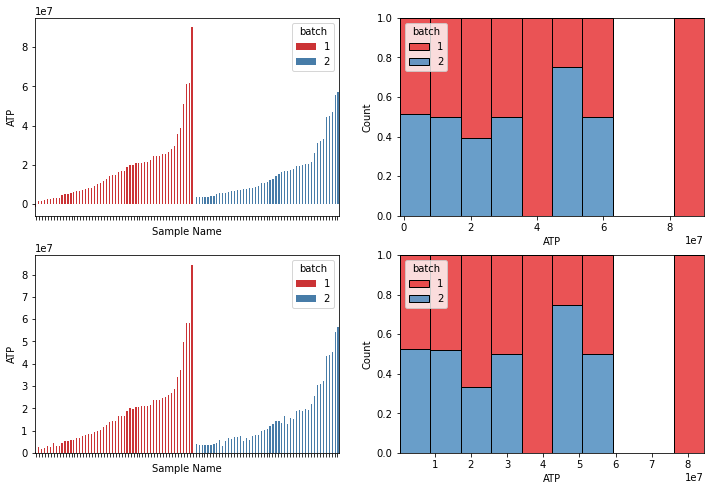

Cholesterol sulfate:33707603.040972844
Cholesterol sulfate:36363364.31239733


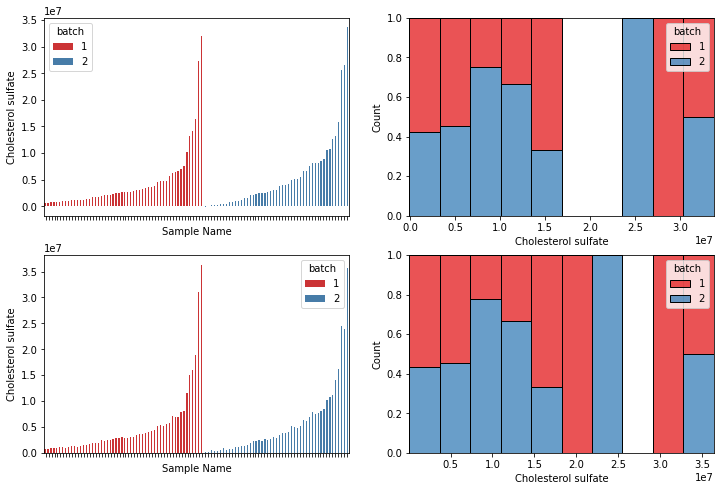

Citrate:83129834.18781951
Citrate:93345550.06273286


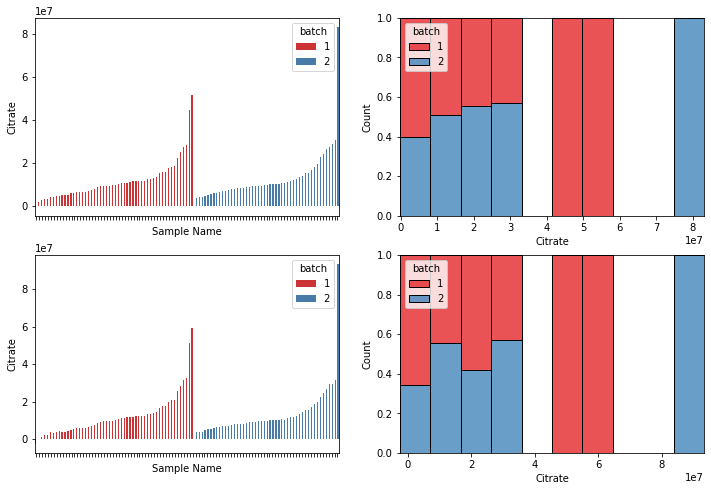

Citrate-isocitrate:307851230.6355686
Citrate-isocitrate:341404009.5301265


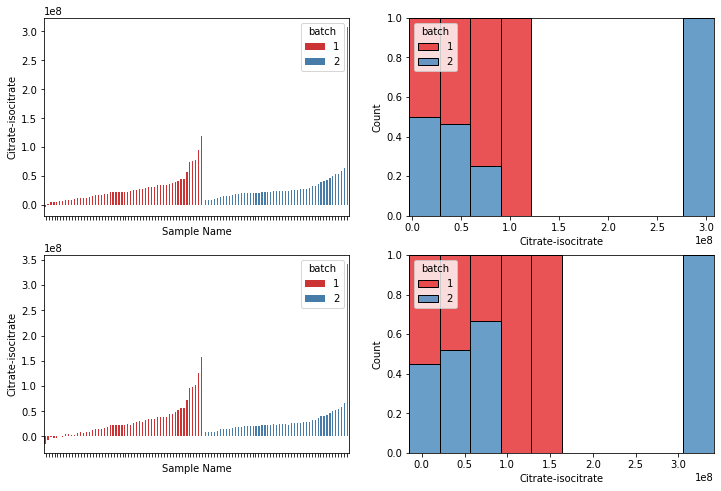

In [48]:
# sum_normed_metab_df=sum_normed_metab_df.sort_index().sort_values(by='batch')
# neg_colnames=[i.replace('-','_') for i in neg_colnames]
neg_colnames=m1_sum_normed_metab_df.columns[(m1_sum_normed_metab_df<0).any()]

for colname in neg_colnames[1:11]:
    f=plt.figure(figsize=(12,8))
    tmp_df_1=m1_sum_normed_metab_df.copy(deep=True)
    tmp_df_1.reset_index(inplace=True)
    tmp_df_1=tmp_df_1.sort_values(by=['batch',colname],ascending=True)
    print(f'{colname}:{tmp_df_1[colname].max()}')

    ax=f.add_subplot(221)
    sns.barplot(data=tmp_df_1,x='Sample Name',y=colname,hue='batch',ax=ax,palette='Set1')
    ax.set_xticklabels([])
    ax=f.add_subplot(222)
    sns.histplot(data=tmp_df_1,x=colname,bins=10,hue='batch',multiple='fill',ax=ax,palette='Set1')

    
    tmp_df_2=m2_combatted_metab_df.copy(deep=True)
    tmp_df_2=tmp_df_2.loc[tmp_df_1['Sample Name'],:]
    tmp_df_2.reset_index(inplace=True)
    # tmp_df_2=tmp_df_2.sort_values(by=['batch',colname],ascending=True)
    
    print(f'{colname}:{tmp_df_2[colname].max()}')
    ax=f.add_subplot(223)
    sns.barplot(data=tmp_df_2,x='Sample Name',y=colname,hue='batch',ax=ax,palette='Set1')
    ax.set_xticklabels([])
    ax=f.add_subplot(224)
    sns.histplot(data=tmp_df_2,x=colname,bins=10,hue='batch',multiple='fill',ax=ax,palette='Set1')

    
    plt.show()

## 20231202 Using

In [25]:
raw_metab_df=pd.read_csv('../data/Using/metab.csv',index_col=0)
metab_num=raw_metab_df.shape[1]
sample_df=pd.read_csv('../data/Using/sample.csv',index_col=0)
metab_df=pd.merge(raw_metab_df,sample_df.loc[:,['batch']],left_index=True,right_on='Sample Name')
metab_num

171

[1.0, 2.0]
PLS Components: 2


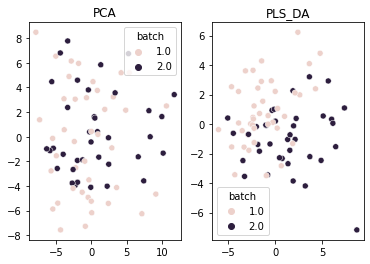

In [26]:
batch_analyzer=BatchEffectAnalyzer(metab_df,metab_num)
batch_analyzer.pca()


In [ ]:

n_clusters=2
model=KMeans(n_clusters=n_clusters)
model.fit(raw_metab_df)
metab_df['kmeans_2']=model.fit_predict(raw_metab_df)
model.fit_predict(raw_metab_df)


In [24]:
metab_df.iloc[:,-2:]

,batch,kmeans_2
Sample Name,,
120136-T,2.0,0
120155-T,2.0,1
120342-T,2.0,0
120367-T,2.0,1
1272,1.0,0
...,...,...
6864,1.0,0
6927,1.0,0
7038,1.0,1
